In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
def readNumEvents(file):
    """
    Moderately efficent way to get the number of events stored in file.
    """
    
    with pylhe._extract_fileobj(file) as fileobj:
        nevts = sum(element.tag == "event" for event, element in ET.iterparse(fileobj, events=["end"]))
    return nevts

In [3]:
# inputFiles = {'zp_dm': '/home/camila/MG5/2mdm_spin1/Events/run_01/unweighted_events.lhe.gz',
#               'mixed_couplings': '/home/camila/MG5/dmsimp_test4/Events/run_03/unweighted_events.lhe.gz'
#               }

inputFiles = {'sd_dm': '/home/camila/MG5/2mdm_spin0_sd/Events/run_06/unweighted_events.lhe.gz',
              'zp_dm': '/home/camila/MG5/2mdm_spin1_zp/Events/run_05/unweighted_events.lhe.gz'
              }


# inputFiles = {'zp_prod': '/home/camila/MG5/2mdm_nlo_spin1_zp/Events/run_05/unweighted_events.lhe.gz',
#               'sd_prod': '/home/camila/MG5/2mdm_nlo_spin0_sd/Events/run_02/unweighted_events.lhe.gz'
#               }

cmsData = pd.read_pickle('../data/Data_CMS.pcl')

In [4]:
events = {}
nevents = {}
for label,f in inputFiles.items():   
    events[label] = pylhe.read_lhe_with_attributes(f)
    nevents[label] = readNumEvents(f)


In [5]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    
    
    if 9900032 in pars.blocks['MASS']:
        model = '2mdm'        
        mZp = pars.blocks['MASS'][9900032] # Z prime mass
        
    elif 55 in pars.blocks['MASS']:
        model = 'dmsimp'
        mZp = pars.blocks['MASS'][55] # Z prime mass
        
    
    if model == '2mdm':
        mS = pars.blocks['BLINPUTS'][2] # dark Higgs (S) mass
        mChi = pars.blocks['MASS'][9000006] # DM mass
        sTheta = pars.blocks['BLINPUTS'][3] # sin theta
        ychi = pars.blocks['FRBLOCK'][1] # coupling of S to DM
        gchi = pars.blocks['ZPRIME'][1] # coupling of mediators to DM
        gq = pars.blocks['ZPRIME'][2] # coupling of mediators to SM
    elif model == 'dmsimp':
        mS = np.nan # dark Higgs mass
        mChi = pars.blocks['MASS'][52] # DM mass
        sTheta = 0
        gchi = pars.blocks['DMINPUTS'][2] # coupling of mediators to DM
        gq = pars.blocks['DMINPUTS'][6] # coupling of mediators to SM  
        

    
        
    parameters[label] = {'mZp' : mZp, 'mDM' : mChi, 'mH2' : mS,
                         'gq' : gq, 'sTheta' : sTheta, 'gx' : gchi, 'ychi' : ychi}
    print(label,': mZp = %1.2f GeV, mH2 = %1.2f GeV, mDM = %1.2f GeV' %(mZp,mS,mChi))

sd_dm : mZp = 2500.00 GeV, mH2 = 600.00 GeV, mDM = 65.00 GeV
zp_dm : mZp = 2000.00 GeV, mH2 = 300.00 GeV, mDM = 65.00 GeV


In [6]:
## jets
pTj1min = 100.
pTjmin = 20.
etamax = 2.4
## MET
minMET = 250.

In [7]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0 for label in inputFiles}
negweight = {label : np.array([]) for label in inputFiles}

for label,evts in events.items():
   
    nevts = nevents[label]
    parameters[label]['Events'] = nevts
    
    for event in evts:

        particles = event.particles
       
        jets = [p for p in particles if abs(p.id) in [1,2,3,4,5,21] and p.status == 1]
        dm = [p for p in particles if abs(p.id) in [9000006, 52, 55, 9900026, 9900032] and p.status == 1]
        med = [p for p in particles if abs(p.id) in [55, 9900026, 9900032] and p.status == 1]
        
        if (len(dm) != 2) and (len(med) != 1):
            continue
            
        # Filter jets
        jetList = []
        for j in jets:
            pT = np.sqrt(j.px**2+j.py**2)
            p = np.sqrt(j.px**2+j.py**2+j.pz**2)
            pL = j.pz
            eta = 0.5*np.log((p+pL)/(p-pL))
            
            if pT < pTjmin:
                continue
            if np.abs(eta) > etamax:
                continue
            jetList.append(j)
        jetList = sorted(jetList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)          

        # Compute MET
        if len(dm) == 2:
            MET = np.sqrt((dm[0].px+dm[1].px)**2 + (dm[0].py+dm[1].py)**2)
        elif len(med) == 1:
            MET = np.sqrt((med[0].px)**2 + (med[0].py)**2)
        
        if len(jetList) == 0:
            continue
        
        pT1 = np.sqrt(jetList[0].px**2+jetList[0].py**2)
        if MET < minMET:
            continue
        if pT1 < pTj1min:
            continue
#         if deltaPhi < 0.5:
#             continue

        weight = event.eventinfo.weight/nevts
            
        if weight < 0:
            negw = weight
            negweight[label] += negw
            negweight[label] = np.append(negweight[label], negw)
            continue
            
        totalweight[label] += weight
        
        # Store relevant data        
        njets[label] = np.append(njets[label],len(jets))
        pTj1[label] = np.append(pTj1[label],pT1)
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],MET)
        

In [8]:
for label in weights:
    frac = np.array(len(negweight[label]))/nevents[label]*100
    print(label, 'Fraction of negative events: %1.2f%%' 
          %frac)

sd_dm Fraction of negative events: 0.10%
zp_dm Fraction of negative events: 3.39%


In [9]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %w)
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(weights.keys())}    

sd_dm total cross-section = 1.135e-03 pb
zp_dm total cross-section = 4.164e-02 pb


In [10]:
## Filter CMS data

modelFilter = { 
 'Datasetyear': 2017,
 'Region': 'Signal',
 'Fit': 'B-only'}


dfModel = cmsData.loc[(cmsData[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]

In [11]:
totalBG = dfModel[dfModel['Process'] == 'TotalSM']
dataCMS = dfModel[dfModel['Process'] == 'Data']

In [12]:
# Auxiliar function for plotting
def getBins(dfModel,rightBin = 1400.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binCenter,binLeft

def getMETbins(dfSingle,bins):

    data = {c : dfSingle[c].iloc[0] for c in bins}

    return data


In [13]:
bins,binCenter,binLeft = getBins(dataCMS)
data = getMETbins(dataCMS,bins)
ptCMS = np.array([data[c] for c in bins])
sumBG = getMETbins(totalBG, bins)
ptBG = np.array([sumBG[c] for c in bins])

In [14]:
lum2017 = 41.5 #fb^-1
binned = {}
metBins = [250,  280,  310,  340,  370,  400,  430,  470,  510, 550,  590,  640,  690,  
            740,  790,  840,  900,  960, 1020, 1090, 1160, 1250, 99999]
for label, pt in pTj1.items():
#     binned[label], bins2 = np.histogram(pt, bins=binLeft, weights=weights[label])
    binned[label], bins2 = np.histogram(pt, bins=metBins, weights=weights[label]*1e3*lum2017)
k=1
brZ = 0.639069
brS = 0.9018403
ptTotal = k*binned['zp_dm'] + k*binned['sd_dm'] + ptBG
zp_bg = binned['zp_dm'] + ptBG

In [15]:
# legend
legend = {
          'Coupling' : 'Vector',
          '$m_{Z^{\prime}}$' : 2000.0,
          '$m_{s}$' : 300.0,
          '$g_{\chi}$' : 2.0,
          '$g_{q}$' : 0.1,
          '$y_{\chi}$' : 1.5,
          '$\sin\\alpha$' : 0.2
           }
textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in legend.items()])

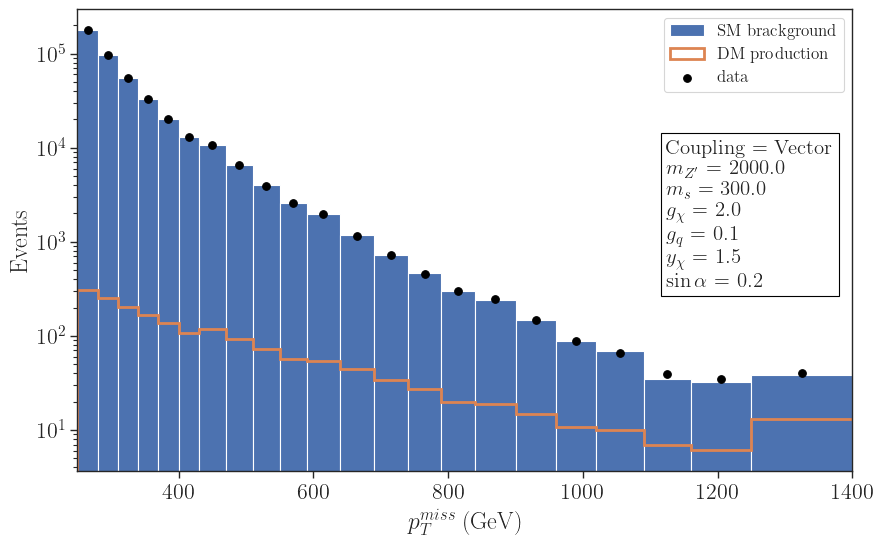

In [30]:
fig = plt.figure(figsize=(10,6))


# plt.hist(binCenter, bins=metBins, weights=k*binned['zp_dm']*brZ, stacked=True, 
#          label=r'spin-1 mediator')
plt.hist(binCenter, bins=binLeft, weights=ptBG, stacked=False, label=r'SM brackground')

plt.hist(binCenter, bins=metBins, weights=binned['sd_dm']+binned['zp_dm'], stacked=False, label=r'DM production',
        histtype='step', linewidth=2.0)
# plt.hist(binCenter, bins=binLeft, weights=binned['zp_dm'], stacked=False, label=r'spin-1 mediator',
#         histtype='step')

 
plt.scatter(x=binCenter, y=ptCMS, s=30, color='black', label='data')
    
plt.yscale('log')
# plt.ylim(1e4,1.8e5)
plt.xlabel(r'$p^{miss}_T$ (GeV)')
plt.ylabel(r'Events')
plt.xlim(250,1400)
plt.legend(loc='upper right', fontsize='x-small')

plt.text(0.76,0.4,textstr,fontsize=15,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

# plt.savefig('../../Pictures/plot-pt.png')
plt.show()

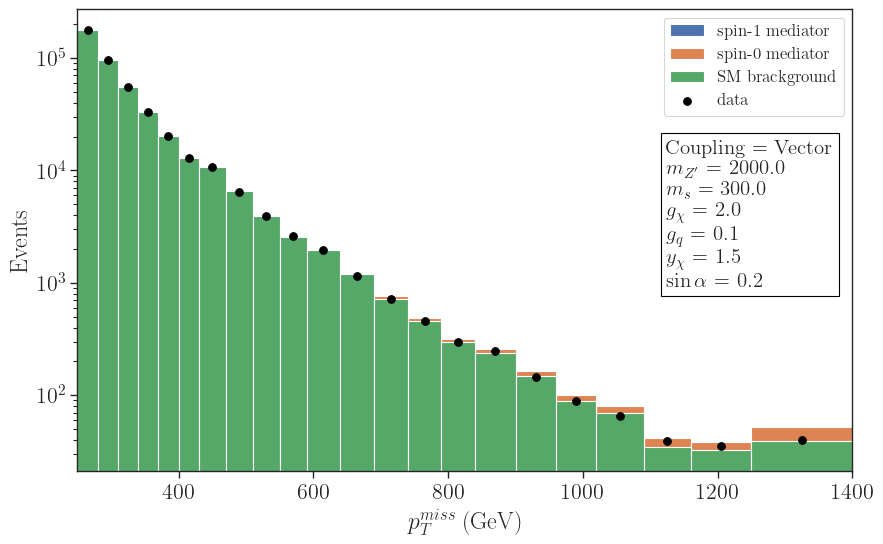

In [31]:
fig = plt.figure(figsize=(10,6))


plt.hist(binCenter, bins=metBins, weights=zp_bg, stacked=True, label=r'spin-1 mediator')
plt.hist(binCenter, bins=binLeft, weights=ptTotal, stacked=True, label=r'spin-0 mediator')
plt.hist(binCenter, bins=binLeft, weights=ptBG, stacked=True, label=r'SM brackground')


plt.scatter(x=binCenter, y=ptCMS, s=30, color='black', label='data')
    
plt.yscale('log')
# plt.ylim(1e4,1.8e5)
plt.xlabel(r'$p^{miss}_T$ (GeV)')
plt.ylabel(r'Events')
plt.xlim(250,1400)
plt.legend(loc='upper right', fontsize='x-small')

plt.text(0.76,0.4,textstr,fontsize=15,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

# plt.savefig('../../Pictures/plot-pt.png')
plt.show()